# Table of Contents

### **0. Importing Libraries & Dataset**
### **1. Hyperparameter Tuning**
#### 1.1 Random Forest
#### 1.2 XGBoost
#### 1.3 TabNet

# 0. Importing Libraries & Dataset

In [ ]:
import pandas as pd
import geopandas as gpd
import shapely.geometry as sg
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.wkt import loads
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score
import torch
import torch.optim
import optuna
from optuna import Trial, visualization
import pickle
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier
import warnings
warnings.filterwarnings('ignore') 

## RUN FROM HERE

In [ ]:
X_train = np.loadtxt('X_train.txt', delimiter=',')
y_train = np.loadtxt('y_train.txt', delimiter=',')
X_test = np.loadtxt('X_test.txt', delimiter=',')
y_test = np.loadtxt('y_test.txt', delimiter=',')

In [ ]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

252618
252618
63155
63155


## 1. Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold

# Define the same number of folds and random state
n_splits = 3
random_state = 0

# Create a cross-validation object for each algorithm with the same settings
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [ ]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history

## 1.1 Tuning Random Forest

In [ ]:
def Objective_rf(trial):
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    n_estimators = trial.suggest_int("n_estimators", 100, 700, step=50)
    max_features = trial.suggest_categorical("max_features", ['log2', 'sqrt'])
    criterion = trial.suggest_categorical("criterion", ['gini', 'entropy', 'log_loss'])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 15, step = 2)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15, step = 2)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    
    rf_params = dict(max_depth = max_depth, n_estimators = n_estimators, 
                     criterion = criterion, min_samples_leaf = min_samples_leaf, 
                     min_samples_split = min_samples_split, bootstrap = bootstrap)

    clf_rf_opt = RandomForestClassifier(**rf_params, n_jobs = -1)    
    score_rf = cross_val_score(clf_rf_opt, X_train, y_train, cv=stratified_kfold, scoring='f1_macro')
    f1_macro = score_rf.mean()    
    return float(f1_macro)

In [ ]:
study_rf = optuna.create_study(directions=['maximize'])
study_rf.optimize(Objective_rf, n_trials=30)

<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

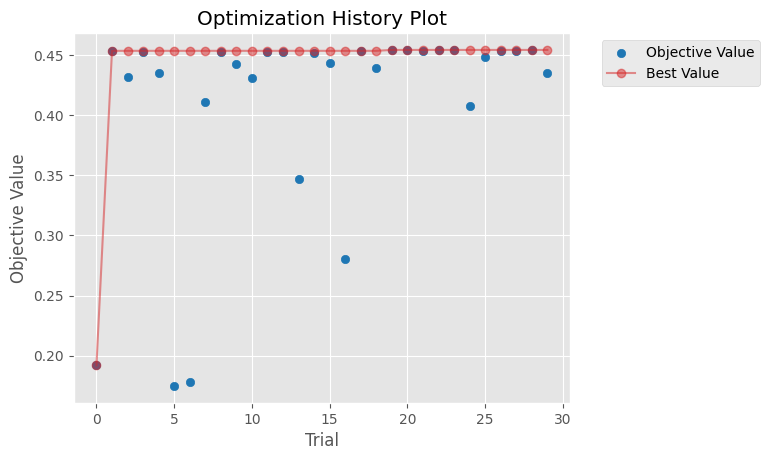

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_rf)

In [ ]:
rf_params = study_rf.best_params
print(rf_params)

{'max_depth': 28, 'n_estimators': 200, 'max_features': 'sqrt', 'criterion': 'log_loss', 'min_samples_leaf': 5, 'min_samples_split': 3, 'bootstrap': False}


In [ ]:
final_params_rf = dict(max_depth=rf_params['max_depth'], n_estimators = rf_params['n_estimators'],
                        max_features = rf_params['max_features'], criterion = rf_params['criterion'], min_samples_leaf = rf_params['min_samples_leaf'],
                        min_samples_split = rf_params['min_samples_split'], bootstrap = rf_params['bootstrap'])

In [ ]:
# instantiate the classifier 
clf_tuned_rf = RandomForestClassifier(**final_params_rf, random_state=0, n_jobs=-1)

# save tuned model
filename_rf = 'tuned_rf_model.pkl'
with open(filename_rf, 'wb') as f:
    pickle.dump(clf_tuned_rf, f)

In [ ]:
# fit the model
clf_tuned_rf.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = clf_tuned_rf.predict(X_test)

### Evaluate

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score, accuracy_score

def evaluate(y_true, y_pred, classifier):
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)

    print("Evaluation metrics for {}:".format(classifier))
    print("Precision macro: {:.4f}".format(precision_macro))
    print("Precision weighted: {:.4f}".format(precision_weighted))
    print("Recall macro: {:.4f}".format(recall_macro))
    print("Recall weighted: {:.4f}".format(recall_weighted))
    print("F1 score macro: {:.4f}".format(f1_macro))
    print("F1 score weighted: {:.4f}".format(f1_weighted))
    print("Balanced accuracy: {:.4f}".format(balanced_accuracy))
    print("Accuracy: {:.4f}".format(accuracy))
    print("Cohen's Kappa Score: {:.4f}".format(cohen_kappa))

In [ ]:
evaluate(y_test, y_pred, "Tuned Random Forest")

Evaluation metrics for Tuned Random Forest:
Precision macro: 0.4842
Precision weighted: 0.5905
Recall macro: 0.4535
Recall weighted: 0.5914
F1 score macro: 0.4635
F1 score weighted: 0.5833
Balanced accuracy: 0.4535
Accuracy: 0.5914
Cohen's Kappa Score: 0.4670


In [ ]:
# Code adapted from medium article (towards data science)
# Kreiger. J.R. (2020). Evaluating a Random Forest Model. Towards Data Science. Retrieved from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

def plot_confusion_matrix(y_true, y_pred, model_name):
    # Class names
    class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

    # Get and reshape confusion matrix data
    matrix = confusion_matrix(y_true, y_pred)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    plt.figure(figsize=(16,7))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':13},
                cmap=plt.cm.Greens, linewidths=0.2,
                vmin=0, vmax=1)  # set fixed scale between 0-1

    # Add labels to the plot
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix for ' + model_name)
    plt.show()

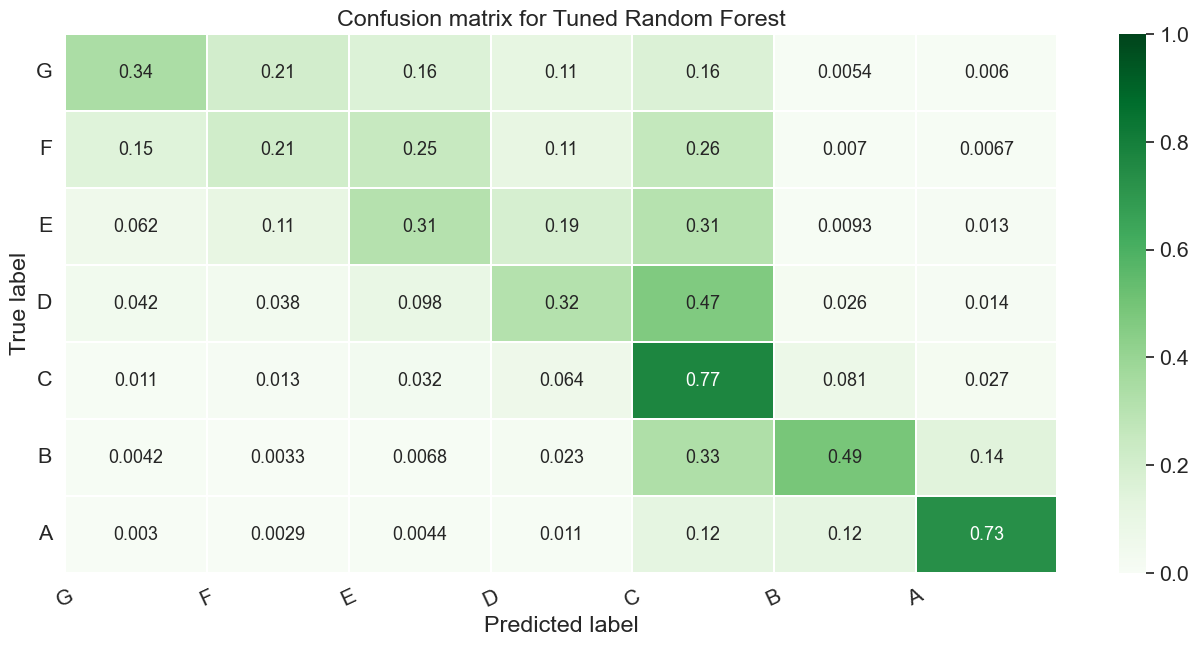

In [ ]:
plot_confusion_matrix(y_test, y_pred, "Tuned Random Forest")

In [ ]:
# Make a list of class names to make classification report more readable
class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

# Print classification report
print(classification_report(y_test, y_pred, target_names = class_names))

              precision    recall  f1-score   support

           G       0.33      0.34      0.34      1846
           F       0.28      0.21      0.24      2555
           E       0.34      0.31      0.33      4069
           D       0.43      0.32      0.37      7240
           C       0.58      0.77      0.66     20175
           B       0.61      0.49      0.54     12088
           A       0.82      0.73      0.77     15182

    accuracy                           0.59     63155
   macro avg       0.48      0.45      0.46     63155
weighted avg       0.59      0.59      0.58     63155



## 1.2 Tuning XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

def Objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700, step=50),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10),
        'gamma':trial.suggest_float('gamma', 0, 1, step = 0.01)
    }
    
    clf_xgb_opt = xgb.XGBClassifier(**params, n_jobs=-1, random_state = 0, tree_method='gpu_hist')
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        clf_xgb_opt.fit(X_train_fold, y_train_fold,
                        early_stopping_rounds = 10,
                        eval_set=[(X_val_fold, y_val_fold)], verbose = False)
        
        y_pred_fold = clf_xgb_opt.predict(X_val_fold)
        f1_fold = f1_score(y_val_fold, y_pred_fold, average='macro')
        scores.append(f1_fold)
    
    f1_macro = np.mean(scores)

    return float(f1_macro)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)
study_xgb = optuna.create_study(directions=['maximize'])
study_xgb.optimize(Objective_xgb, n_trials=30)

<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

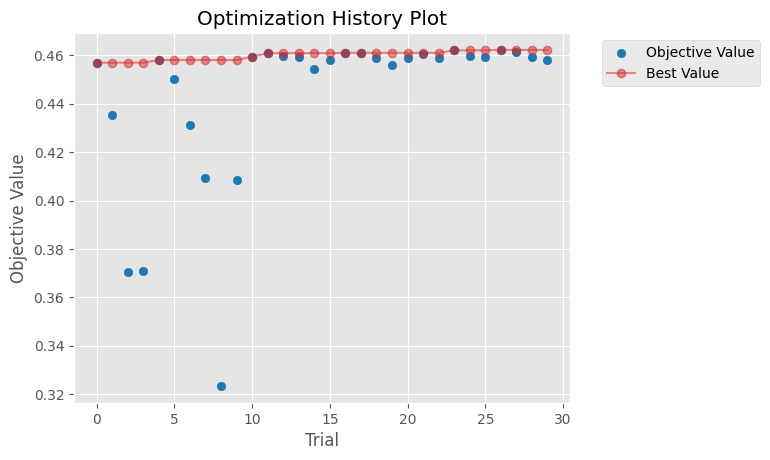

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_xgb)

### Save best parameters and run best model

In [ ]:
xgb_params = study_xgb.best_params
print(xgb_params)

{'max_depth': 24, 'n_estimators': 600, 'eta': 0.025754181305708345, 'subsample': 0.9608784508636286, 'colsample_bytree': 0.9286899661385983, 'reg_alpha': 0.010065427727559563, 'reg_lambda': 9.348748509801002, 'gamma': 0.8200000000000001}


In [ ]:
final_params_xgb = dict(max_depth=xgb_params['max_depth'], n_estimators = xgb_params['n_estimators'],
                        eta = xgb_params['eta'], subsample = xgb_params['subsample'], colsample_bytree = xgb_params['colsample_bytree'],
                        reg_alpha = xgb_params['reg_alpha'], reg_lambda = xgb_params['reg_lambda'], gamma = xgb_params['gamma'])

In [ ]:
clf_tuned_xgb = xgb.XGBClassifier(**final_params_xgb, n_jobs=-1, random_state = 0, tree_method='gpu_hist')

# save tuned model
filename_xgb = 'tuned_xgb_model.pkl'
with open(filename_xgb, 'wb') as f:
    pickle.dump(clf_tuned_xgb, f)

In [ ]:
clf_tuned_xgb.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred_xgb = clf_tuned_xgb.predict(X_test)

### Evaluate

In [ ]:
evaluate(y_test, y_pred_xgb, "Tuned XGBoost")

Evaluation metrics for Tuned XGBoost:
Precision macro: 0.4900
Precision weighted: 0.5982
Recall macro: 0.4625
Recall weighted: 0.5968
F1 score macro: 0.4710
F1 score weighted: 0.5897
Balanced accuracy: 0.4625
Accuracy: 0.5968
Cohen's Kappa Score: 0.4749


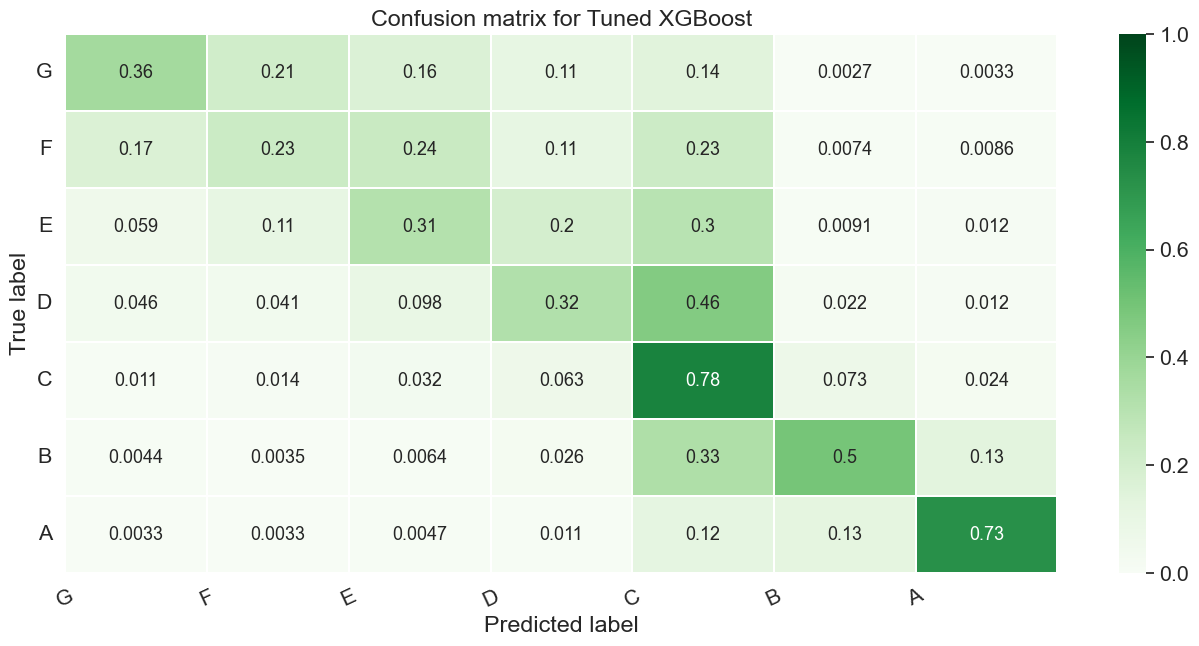

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb, "Tuned XGBoost")

In [ ]:
# Print classification report
class_names = ['G', 'F', 'E', 'D', 'C', 'B', 'A']

print(classification_report(y_test, y_pred_xgb, target_names = class_names))

              precision    recall  f1-score   support

           G       0.33      0.36      0.35      1846
           F       0.28      0.23      0.26      2555
           E       0.34      0.31      0.33      4069
           D       0.43      0.32      0.37      7240
           C       0.58      0.78      0.67     20175
           B       0.62      0.50      0.55     12088
           A       0.83      0.73      0.78     15182

    accuracy                           0.60     63155
   macro avg       0.49      0.46      0.47     63155
weighted avg       0.60      0.60      0.59     63155



## 1.3 Tuning TabNet

In [ ]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device_name)

cuda


In [ ]:
# convert y_train and y_test to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [ ]:
# Implementation based on a Kaggle Notebook from Neil Gibbons
# Gibbons, N. (2021). Tuning TabNet with Optuna [Notebook]. Kaggle. Retrieved from https://www.kaggle.com/code/neilgibbons/tuning-tabnet-with-optuna

In [ ]:
def Objective_tabnet(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 8, 32, step=8)
    n_steps = trial.suggest_int("n_steps", 3, 10, step=1)
    gamma = trial.suggest_float("gamma", 0.01, 0.2, step=0.01)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    optimizer_params = dict(lr=2e-2, weight_decay=1e-5)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                     lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                     optimizer_params=optimizer_params, mask_type=mask_type,
                     n_shared=n_shared,
                     scheduler_params=dict(patience=trial.suggest_int("patienceScheduler",low=3,high=6),  
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0)
        
    clf_tab_opt = TabNetClassifier(**tabnet_params, device_name = 'cuda' if torch.cuda.is_available() else 'cpu')
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_train_fold = X_train[train_idx]
        y_train_fold = y_train[train_idx]
        X_val_fold = X_train[val_idx]
        y_val_fold = y_train[val_idx]

        clf_tab_opt.fit(X_train=X_train_fold, y_train=y_train_fold,
                        eval_set=[(X_val_fold, y_val_fold)],
                        patience=trial.suggest_int("patience",low=4,high=8), 
                        batch_size=12000,
                        max_epochs=trial.suggest_int("max_epochs", 10, 50))
        
        y_pred_fold = clf_tab_opt.predict(X_val_fold)
        f1_score_fold = f1_score(y_val_fold, y_pred_fold, average='macro')
        scores.append(f1_score_fold)
    
    f1_macro = np.mean(scores)
    
    return float(f1_macro)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.DEBUG)
study_tabnet= optuna.create_study(directions=['maximize'])
study_tabnet.optimize(Objective_tabnet, n_trials=30)

<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

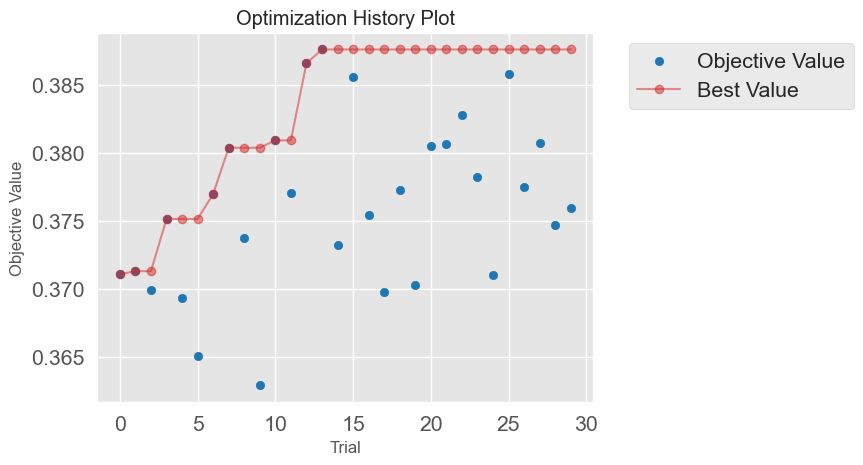

In [ ]:
optuna.visualization.matplotlib.plot_optimization_history(study_tabnet)

### Save best parameters, and run best model

In [ ]:
TabNet_params = study_tabnet.best_params
print(TabNet_params)

{'mask_type': 'entmax', 'n_da': 24, 'n_steps': 10, 'gamma': 0.06999999999999999, 'n_shared': 2, 'lambda_sparse': 3.4644780488834365e-05, 'patienceScheduler': 6, 'patience': 8, 'max_epochs': 49}


In [ ]:
final_params_tab = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                     lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                     scheduler_params=dict(patience=TabNet_params['patienceScheduler'],
                                           min_lr=1e-5,
                                           factor=0.5,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=0,
                     )

epochs = TabNet_params['max_epochs']

In [ ]:
clf_tuned_tab.fit(X_train=X_train, y_train=y_train,
          patience=TabNet_params['patience'], batch_size=12000, max_epochs=epochs)

In [ ]:
# Predict on the test set 
y_prob_tabnet = clf_tuned_tab.predict_proba(X_test)
y_pred_tabnet = np.argmax(y_prob_tabnet, axis=1)

### Evaluate

In [ ]:
evaluate(y_test, y_pred_tabnet, "Tuned TabNet")

Evaluation metrics for Tuned TabNet:
Precision macro: 0.4478
Precision weighted: 0.5510
Recall macro: 0.4054
Recall weighted: 0.5490
F1 score macro: 0.4088
F1 score weighted: 0.5303
Balanced accuracy: 0.4054
Accuracy: 0.5490
Cohen's Kappa Score: 0.4038


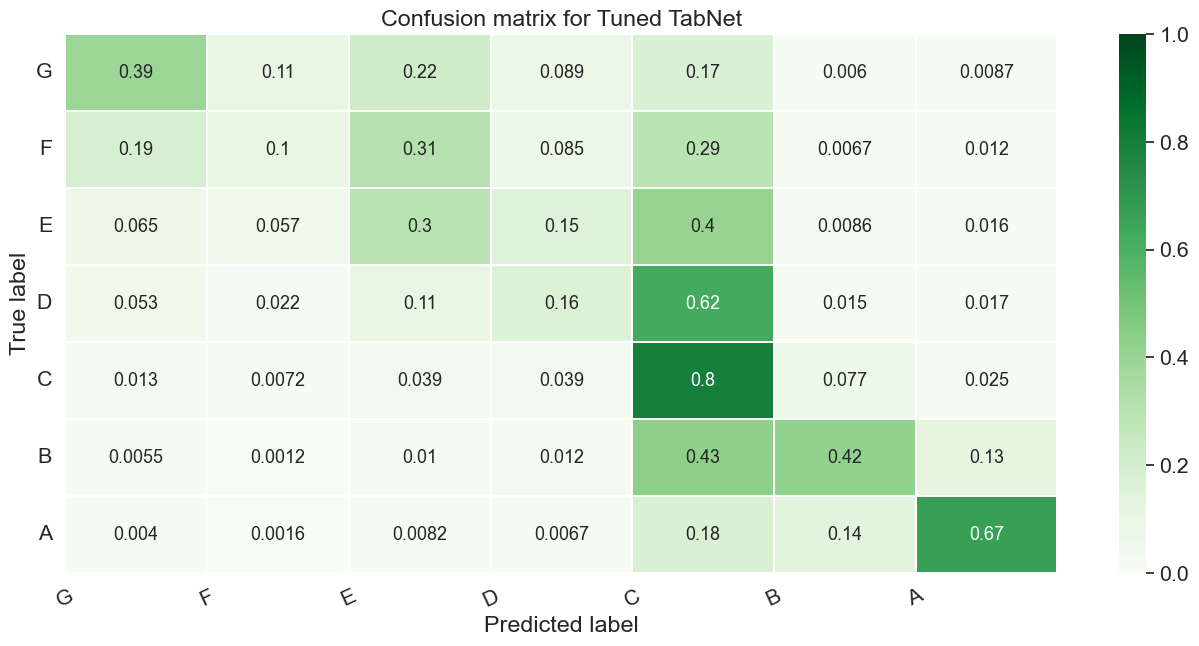

In [ ]:
plot_confusion_matrix(y_test, y_pred_tabnet, "Tuned TabNet")

In [ ]:
# Printing classification report
print(classification_report(y_test, y_pred_tabnet, target_names = class_names))

              precision    recall  f1-score   support

           G       0.32      0.39      0.35      1846
           F       0.26      0.10      0.15      2555
           E       0.28      0.30      0.29      4069
           D       0.37      0.16      0.23      7240
           C       0.52      0.80      0.63     20175
           B       0.57      0.42      0.48     12088
           A       0.82      0.67      0.73     15182

    accuracy                           0.55     63155
   macro avg       0.45      0.41      0.41     63155
weighted avg       0.55      0.55      0.53     63155

